In [0]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from datetime import date, time
import statistics
from datetime import datetime
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import gc

def get_coin_data(start_str: str, end_str: str, coin_name: str) -> pd.DataFrame:
    """ 
    Return a data frame with daily statsabout a crypto currency
    Contains: Date Open* High Low Close** Volume Market Cap
    Args:
    start_str (str): start of the time series (20100101 if None)
    end_str (str): end of the time seires (today's date if None)
    coin_name (str): https://coinmarketcap name for the coin of interest
    Returns: 
    DataFrame with coin prices
    """
    # check the input
    if start_str is None:
        start_str = '20100101'
    if end_str is None:
        end_str = str(date.today())
    if coin_name is None:
        raise
        
    # replace - from the dates with ''
    start_str = start_str.replace('-', '')
    end_str = end_str.replace('-', '')
    # get the data and convert to pandas dataframe
    
    base_uri = f'https://coinmarketcap.com/currencies/{coin_name}/historical-data/?start={start_str}&end={end_str}'
    price_df = pd.read_html(base_uri)[0]
    return price_df


def clean_input_data(df: pd.DataFrame) -> pd.DataFrame:
    """ 
    Cleans the input data frame. Converts data inot a usable foramt,
    converts column names to lowercase and removes aspaces and odd chars
    Converts all of the numeric columns to numeric nad inputes the erros
    with the median value sper column
    Args:
    df (DataFrame): imput data frame with coin prices
    Returns
    df (DataFrame): cleaned data frame with coin prices
    """
    # convert column names to lowercase
    column_names = df.columns.values
    column_names_modified = dict()
    
    for column in column_names:
        column_names_modified[column] = column.lower().replace('*', '').replace(' ', '_')
    df.rename(columns=column_names_modified, inplace=True) 
    
    # convert the date to standard format
    df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%b %d, %Y').date()) 
    # convert the rest of the columns to numeric
    numeric_columns = ['open', 'high', 'low', 'close', 'volume', 'market_cap']
    df[numeric_columns] = df[numeric_columns].apply(lambda x: pd.to_numeric(x, errors='coerce'), axis=1)
    
    # impute the missing data with the median values
    for column in numeric_columns:
        df[column] = df[column].fillna(statistics.median(df[column]))
    return df

 
def train_test_split(df: pd.DataFrame, train_size: float) -> tuple:
    """
    This function splits the data into training_set and test_set based on the given train_size
    Args:
    df: Pandas Dataframe
    train_size: proportion of the data to be used for training
    Return: train_set and test_set as pandas DataFrame
    """
    return df[:int(train_size*len(df))], df[int(train_size*len(df)):]


def create_inputs(df: pd.DataFrame, window_len: int) -> list:
    """
    This function will create input array X from the given dataset and will normalize 'Close' and 'Volume' between 0 and 1
    Args:
     data: pandas DataFrame, this could be either training_set or test_set
    coins: coin datas which will be used as the input. Default is 'btc', 'eth'
    window_len: is an intiger to be used as the look back window for creating a single input sample.
    Returns: 
    X, the input for our model as a python list which later needs to be converted to numpy array.
    """
    inputs = []
    for i in range(len(df) - window_len):
        temp_set = df[i:(i + window_len)].copy()
        inputs.append(temp_set.values)
        #inputs.append((temp_set / temp_set.iloc[0] - 1).values)
    return inputs


def create_outputs(df: pd.DataFrame, target_col: str, window_len: int):
  return df[target_col][window_len:].values
  #y = df[target_col][window_len:].values
  #return y / df[target_col][:-window_len].values - 1


def to_array(df: pd.DataFrame) -> np.ndarray:
    """
    This function will convert list of inputs to a numpy array
    data: DataFrame
    Return: numpy array
    """
    x = [np.array(df[i]) for i in range (len(df))]
    return np.array(x)


def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(20, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)


def calculate_strategy_returns(df: pd.DataFrame) -> pd.DataFrame:
  df['pred_diffs'] = df['prediction'].diff(1)
  df['target_diffs'] = df['target'].diff(1)
  df['wait_and_hold_strategy_returns'] = df['target'].diff(1)
  df['lstm_position']  = np.where(df['pred_diffs'] > 0,1, -1)
  df['lstm_retuns'] = df['lstm_position'] * df['target_diffs']
  df['lstm_retuns_cumsum'] = df['lstm_retuns'].cumsum()
  df['wait_and_hold_cumsum'] = df['wait_and_hold_strategy_returns'].cumsum()
  return df

In [0]:
neurons = 50                  # number of hidden units in the LSTM layer
activation_function = 'tanh'  # activation function for LSTM and Dense layer
loss = 'mse'                  # loss function for calculating the gradient, in this case Mean Squared Error
optimizer= 'nadam'             # optimizer for appljying gradient decent
dropout = 0.25                # dropout ratio used after each LSTM layer to avoid overfitting
batch_size = 4                # number of sample per training round
epochs = 50                   # number of passes through the data
window_len = 10               # is an intiger to be used as the look back window for creating a single input sample.



def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  """
  This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
  and finally a dense layer to produce the output using keras' sequential model.
  inputs: input data as numpy array
  Args:
  output_size: number of predictions per input sample
  neurons: number of neurons/ units in the LSTM layer
  active_func: Activation function to be used in LSTM layers and Dense layer
  dropout: dropout ration, default is 0.25
  loss: loss function for calculating the gradient
  optimizer: type of optimizer to backpropagate the gradient
  Return: Keras sequential model and model summary
  """
  lstm = Sequential()
  lstm.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  lstm.add(Dropout(dropout))
  lstm.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  lstm.add(Dropout(dropout))
  lstm.add(LSTM(neurons, activation=activ_func))
  lstm.add(Dropout(dropout))
  lstm.add(Dense(units=output_size))
  lstm.add(Activation(activ_func))
  lstm.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
  lstm.summary()
  return lstm

## Download the Market Data

In [52]:
market_data = get_coin_data(None, None, 'bitcoin')
market_data.head()

,Date,Open*,High,Low,Close**,Volume,Market Cap
0,"Oct 22, 2019",8243.40,8296.65,8074.46,8078.20,16803377857,145469660005
1,"Oct 21, 2019",8225.12,8296.69,8196.42,8243.72,15868748866,148432733155
2,"Oct 20, 2019",7997.81,8281.82,7949.44,8222.08,15504249442,148026597064
3,"Oct 19, 2019",7973.80,8082.63,7944.78,7988.56,13797825640,143808163807
4,"Oct 18, 2019",8100.93,8138.41,7902.16,7973.21,15651592610,143517630376


## Clean the Data

In [53]:
# rename the columns
column_names = market_data.columns.values
market_data.columns = [column.lower().replace('*', '').replace(' ', '_')  for column in column_names]
# convert the dates to datetime and all columns to numeric
clean_data = clean_input_data(market_data)
# reverse the dataframe
clean_data = clean_data.iloc[::-1]
# turn the date column into and index
clean_data = clean_data.set_index('date')
clean_data.head()

,open,high,low,close,volume,market_cap
date,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,315108000.0,1.488567e+09
2013-04-29,134.44,147.49,134.00,144.54,315108000.0,1.603769e+09
2013-04-30,144.00,146.93,134.05,139.00,315108000.0,1.542813e+09
2013-05-01,139.00,139.89,107.72,116.99,315108000.0,1.298955e+09
2013-05-02,116.38,125.60,92.28,105.21,315108000.0,1.168517e+09


## Split into Training, Testing and Validation datasets.


In [54]:
# create validation dataset
clean_data, validation = train_test_split(clean_data, 1 - 45/2367)
print(f'clean_data: {clean_data.shape}, validation: {validation.shape}')
# create traing and testing dataset
train, test = train_test_split(clean_data, 0.8)
print(f'train: {train.shape}, test: {test.shape}')

clean_data: (2323, 6), validation: (46, 6)
train: (1858, 6), test: (465, 6)


## Plot Training and Testing Data

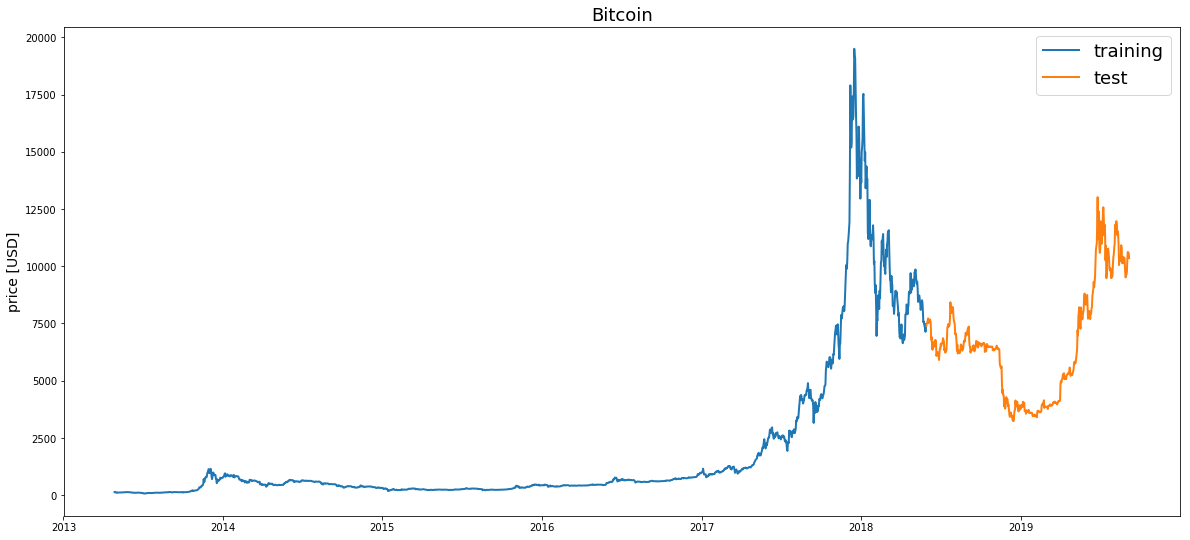

In [26]:
line_plot(train['close'], test['close'], 'training', 'test', title='Bitcoin')

## Plot Testing and Validation Data

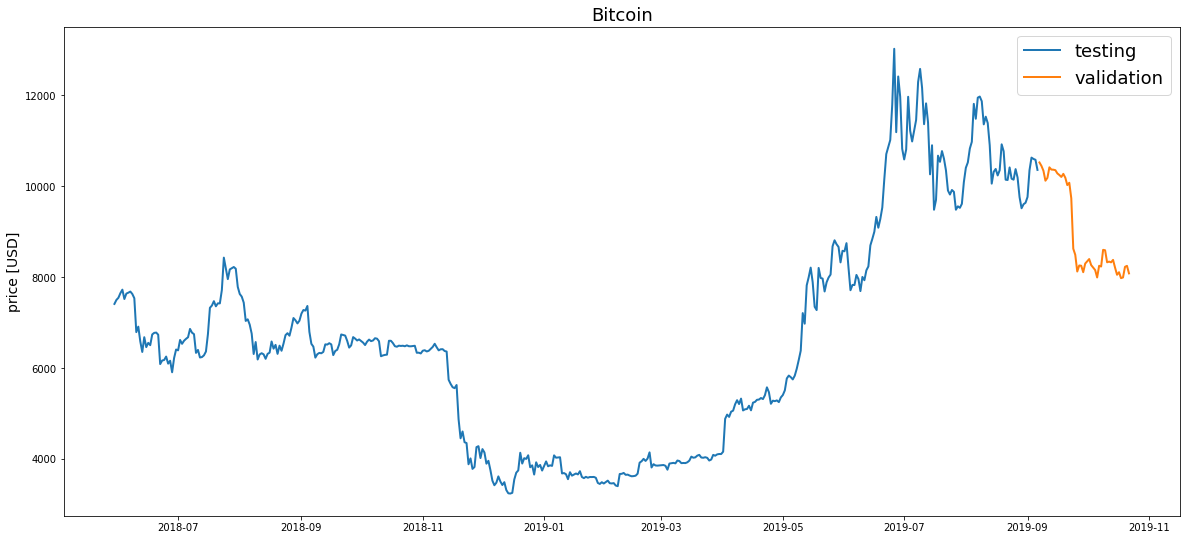

In [27]:
line_plot(test['close'], validation['close'], 'testing', 'validation', title='Bitcoin')

## create train test and validation and scale the variables


In [66]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

# train
train_scaled = pd.DataFrame(min_max_scaler.fit_transform(train), 
                             columns=train.columns, 
                             index=train.index)

# test 
test_scaled = pd.DataFrame(min_max_scaler.fit_transform(test), 
                             columns=test.columns, 
                             index=test.index)

# validation
validation_scaled = pd.DataFrame(min_max_scaler.fit_transform(validation), 
                             columns=validation.columns, 
                             index=validation.index)

train.head()

,open,high,low,close,volume,market_cap
date,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,315108000.0,1.488567e+09
2013-04-29,134.44,147.49,134.00,144.54,315108000.0,1.603769e+09
2013-04-30,144.00,146.93,134.05,139.00,315108000.0,1.542813e+09
2013-05-01,139.00,139.89,107.72,116.99,315108000.0,1.298955e+09
2013-05-02,116.38,125.60,92.28,105.21,315108000.0,1.168517e+09


## Choose the best sequence length

In [0]:
mae_list = list()
for i in range(10):
  window_len = i + 1
  X_train = create_inputs(train, window_len)
  X_test = create_inputs(test, window_len)

  X_train = np.array(X_train)
  X_test = np.array(X_test)

  y_train = create_outputs(train, 'close', window_len)
  y_test = create_outputs(test, 'close', window_len)

  # random seed for reproducibility
  np.random.seed(202)
  # initialise model architecture
  btc_model = build_model(X_train, output_size=1, neurons=neurons)
  # train model on data
  btc_history = btc_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_test, y_test), shuffle=True)

  #  predict on the test data
  targets = test['close'][10:]
  preds = btc_model.predict(X_test).squeeze()
  # calculate mean absolute error
  mae_list.append(f'model with window length: {i}, MAE on test data is: {mean_absolute_error(preds, y_test)}')

for i in mae_list:
  print(i)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 20)             2160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 20)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 20)             3280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 20)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         


## Generate Sequences and Train the final model

In [0]:
window_len = 7
X_train = create_inputs(train_scaled, window_len)
X_test = create_inputs(test_scaled, window_len)
X_validation = create_inputs(validation_scaled, window_len)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_validation = np.array(X_validation)

y_train = create_outputs(train_scaled, 'close', window_len)
y_test = create_outputs(test_scaled, 'close', window_len)
y_validation = create_outputs(validation_scaled, 'close', window_len)

In [75]:
# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
btc_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
btc_history = btc_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test), shuffle=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 7, 50)             11400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7, 50)             20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

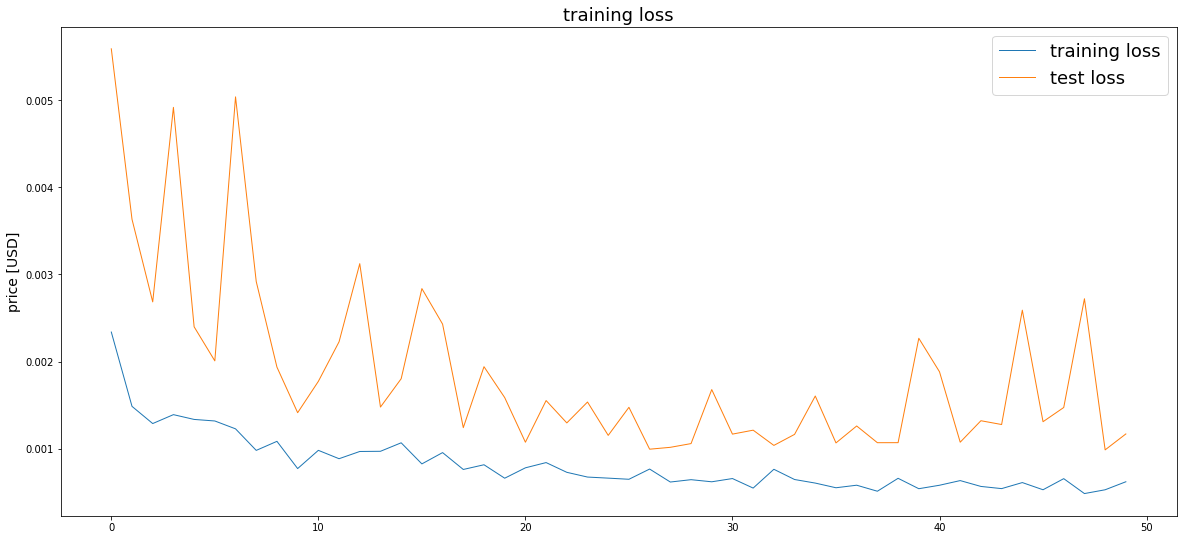

In [76]:

line_plot(btc_history.history['loss'], btc_history.history['val_loss'], 'training loss', 'test loss', lw=1, title='training loss')

## Predcitions on the test data

In [77]:
#  predict on the test data
targets = test_scaled['close'][window_len:]
preds = btc_model.predict(X_test).squeeze()
# calculate mean absolute error
mean_absolute_error(preds, y_test)

0.023065848984746132

## Plots

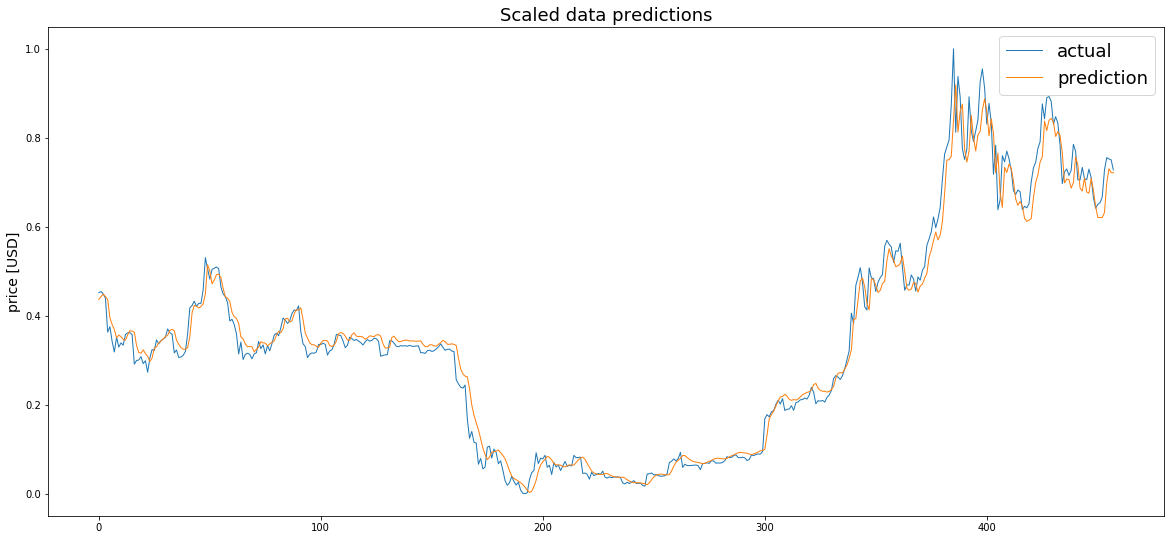

In [78]:
line_plot(y_test, preds, 'actual', 'prediction', lw=1, title='Scaled data predictions')

## Predict on the Validation Set

In [79]:
#  predict on the vslidation data
targets = validation_scaled['close'][window_len:]
preds = btc_model.predict(X_validation).squeeze()
mean_absolute_error(preds, y_validation)

0.09699825260978394

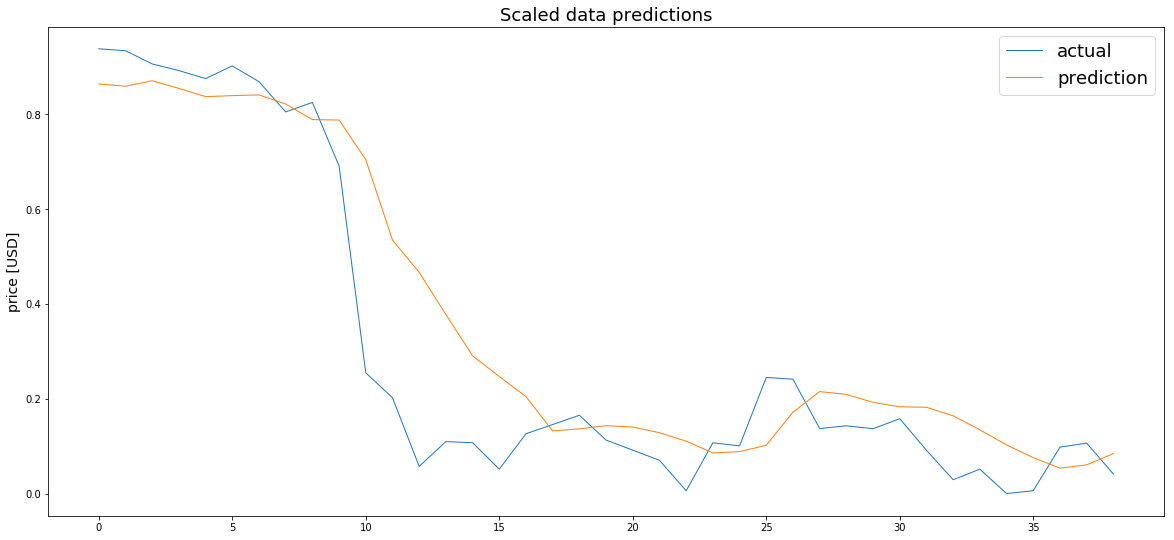

In [80]:
line_plot(y_validation, preds, 'actual', 'prediction', lw=1, title='Scaled data predictions')

In [0]:

preds = pd.Series(index=targets.index, data=preds)

## Test perofrmace of both trading Strategies

In [0]:
validation_results = pd.DataFrame({'target': validation['close'][window_len:], 'prediction': preds}, index = preds.index)

In [0]:
portfolio_results = calculate_strategy_returns(validation_results)

In [84]:
portfolio_results[['wait_and_hold_strategy_returns', 'lstm_retuns', 'lstm_retuns_cumsum', 'wait_and_hold_cumsum']]

,wait_and_hold_strategy_returns,lstm_retuns,lstm_retuns_cumsum,wait_and_hold_cumsum
date,,,,
2019-09-14,NaN,NaN,NaN,NaN
2019-09-15,-10.34,10.34,10.34,-10.34
2019-09-16,-70.92,-70.92,-60.58,-81.26
2019-09-17,-35.52,35.52,-25.06,-116.78
2019-09-18,-43.02,43.02,17.96,-159.80
2019-09-19,68.16,68.16,86.12,-91.64
2019-09-20,-84.77,-84.77,1.35,-176.41
2019-09-21,-161.92,161.92,163.27,-338.33
2019-09-22,50.67,-50.67,112.60,-287.66


## Plot trading strategy results

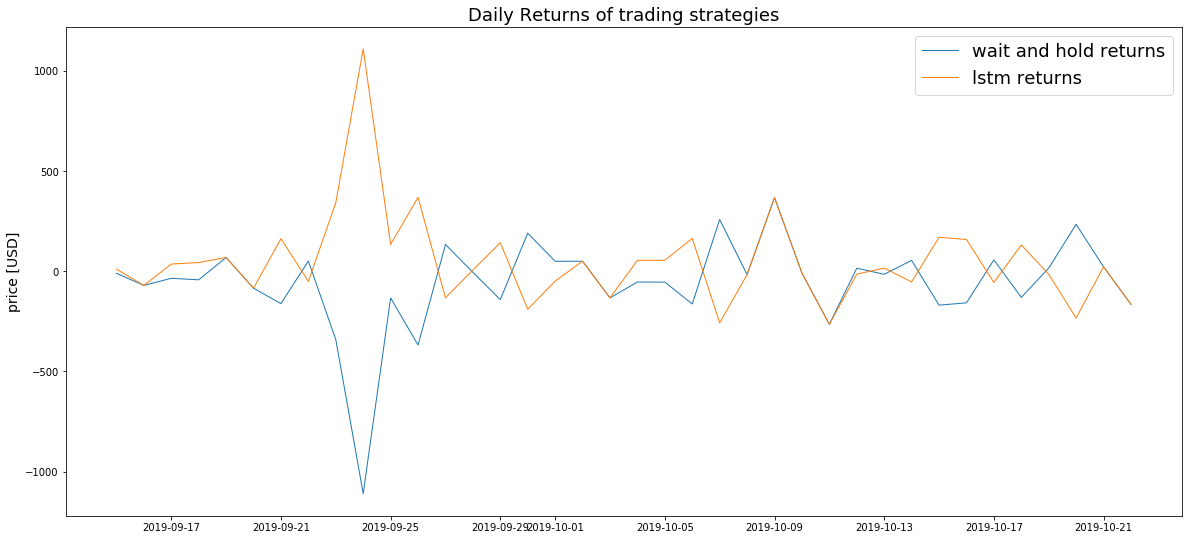

In [86]:
line_plot(portfolio_results['wait_and_hold_strategy_returns'], portfolio_results['lstm_retuns'], 'wait and hold returns', 'lstm returns', lw=1, title='Daily Returns of trading strategies')

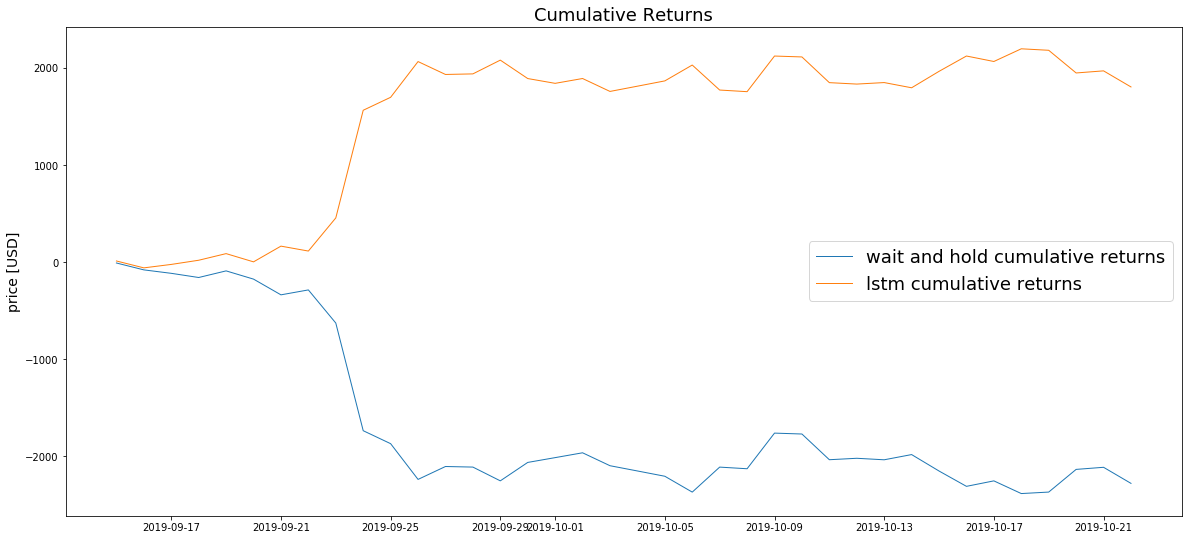

In [87]:
line_plot(portfolio_results['wait_and_hold_cumsum'], portfolio_results['lstm_retuns_cumsum'], 'wait and hold cumulative returns', 'lstm cumulative returns', lw=1, title='Cumulative Returns')